# Laden benötigter Pakete

In [223]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pylab import rcParams
from sklearn.inspection import permutation_importance
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error,  median_absolute_error
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


RANDOM_SEED = 42
rcParams['figure.figsize'] = 22, 10
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Einlesen der preparierten Daten

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/andreashrb/Python_for_ML_Project/main/data/input_output_data.csv', sep=',', encoding='utf-8', index_col=[0,1], decimal=".", thousands=",", parse_dates=['date'])


In [5]:
df.head()

lme_copper_cash__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)  \
id date                                                                                  
1  2012-01-08                                        8602.117939                         
   2012-01-15                                        8602.117939                         
   2012-01-22                                        8602.117939                         
   2012-01-29                                        8602.117939                         
   2012-02-05                                        8602.117939                         

               lme_copper_cash__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)  \
id date                                                                                 
1  2012-01-08                                       10935.500183                        
   2012-01-15                                       10935.500183                        
   2012-01-22                                       10935.500183                        
   2012-01-29                                       10935.500183                        
   2012-02-05                                       10935.500183                        

               lme_copper_cash__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)  \
id date                                                                                   
1  2012-01-08                                        9020.109055                          
   2012-01-15                                        9020.109055                          
   2012-01-22                                        9020.109055                          
   2012-01-29                                        9020.109055                          
   2012-02-05                                        9020.109055                          

               lme_copper_cash__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)  \
id date                                                                                 
1  2012-01-08                                        5011.405561                        
   2012-01-15                                        5011.405561                        
   2012-01-22                                        5011.405561                        
   2012-01-29                                        5011.405561                        
   2012-02-05                                        5011.405561                        

               lme_copper_cash__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)  \
id date                                                                                   
1  2012-01-08                                        7080.385602                          
   2012-01-15                                        7080.385602                          
   2012-01-22                                        7080.385602                          
   2012-01-29                                        7080.385602                          
   2012-02-05                                        7080.385602                          

               lme_copper_cash__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)  \
id date                                                                                 
1  2012-01-08                                       12767.469234                        
   2012-01-15                                       12767.469234                        
   2012-01-22                                       12767.469234                        
   2012-01-29                                       12767.469234                        
   2012-02-05                                       12767.469234                        

               lme_copper_cash__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)  \
id date                                                                                  
1  2012-01-08                                       1070

# Preprocessing and Modelling

Im Rahmen dieses Notebooks sollen die zugrundeliegenden Daten (s.o.) für verschiedene Modelle vorbereitet werden, um anschließend eine Prognose für den Kupferpreis (Spalte im DataFrame: lme_copper_cash) mithilfe dieser Modelle abzuleiten.

Verwendet werden sollen sowohl klassische Machine Learning-Methoden, als auch Methoden des Deep Learnings.

## Decision Trees (Random Forest / XGBoost)

Immer wieder sehr erfolgreich, und zu den klassischen Machine Learning-Methoden zählend, werden Decision Tree's diskutiert.
Diese Decision Tree's können durchaus auch für Zeitreihenprobleme genutzt werden. Anders als z.B. ein ARIMA-Modell, welches für die Lösung von Zeitreihenproblemen optimiert ist, sind Decision Trees originär nicht speziell für die Lösung von Zeitreihenproblemen entwickelt worden. Decision Tree's sind allerdings in der Lage Klassifikations- als auch Regressionsprobleme zu lösen. Somit eignen sie sich ebenfalls zur Lösung von Zeitreihenproblemen, insbesondere multivariaten Zeitreihenproblemen.

In der gesamten Data Science Community sind insbesondere der Random Forest und der Gradient Boosting Tree (auch: XGBoost) immer wieder stark performende ML-Modelle und schneiden in diversen ML-Wettbewerben, z.B. auch auf Kaggle, sehr gut ab, weshalb auch in Rahmen dieses Notebooks der Random Forest / XG Boost stellvertretend für die Kategorie der Decision Trees unter den vielzähligen Machine Learning Modellen angewendet werden sollen.

Die notwendigen Data Preprocessing-Schritte auf den bereits vorbereiteten Daten mit bereits erfolgter Feature Extraction und Feature Selection zur Anwendung eines Decision Tree (speziell: Random Forest / XG Boost) orientieren sich an folgender Quelle:
https://www.tmwr.org/pre-proc-table.html.

Demnach ist für Random Forest, als auch Boosting Tree-Modelle, lediglich die Imputation als zwingende Preprocessing-Maßnahme anzuwenden. Diese wurde bereits im Rahmen der Feature Selection im Teil "Data Preparation" vorgenommen.

### Train-Test-Split

In [6]:
# Länge des DataFrames
print(len(df))

470


In [7]:
# Einfacher Train-Test-Split

train_size = int(len(df)*0.8)
test_size = len(df) - train_size
df_train, df_test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

In [8]:
print(df_train.shape)
print(df_test.shape)

(376, 232)
(94, 232)


**Trainingsdaten:** 376 Datensätze mit 232 Features

**Testdaten:** 94 Datensätze mit 232 Features

Unter den 232 Features befindet sich allerdings ebenso noch die Zielvariable "lme_copper_cash".
Diese muss im Folgenden noch separiert werden, um zu folgender Struktur zu kommen:

- x_train
- y_train
- x_test
- y_test

In [9]:
# Separieren von Input- und Output-Daten (x,y)
x_train = df_train.loc[:, df.columns != 'lme_copper_cash']
y_train = df_train['lme_copper_cash']

x_test = df_test.loc[:, df.columns != 'lme_copper_cash']
y_test = df_test['lme_copper_cash']

In [10]:
print(x_train.shape)
print(y_train.shape)

(376, 231)
(376,)


In [11]:
print(x_test.shape)
print(y_test.shape)

(94, 231)
(94,)


### Modelling

### Random Forest Regressor

In [12]:
# Erstellen des Modells ohne Festlegung bestimmter Hyperparameter (Verwendung der Default-Werte)
rf_regr = RandomForestRegressor(random_state=1234, verbose=True)


In [13]:
# Trainieren des Modells
rf_regr.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


RandomForestRegressor(random_state=1234, verbose=True)

In [14]:
rf_regr.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([6467.152     , 6476.0725    , 6505.6845    , 6506.4235    ,
       6512.0905    , 6491.2715    , 6478.07075   , 6340.04033333,
       6046.24841667, 5959.32291667, 5870.32183333, 5794.12533333,
       5755.9725    , 5761.5995    , 5876.7845    , 5922.42233333,
       5930.268     , 5971.68316667, 6045.78208333, 5975.95566667,
       5816.424     , 5692.43925   , 5646.24175   , 5645.348     ,
       5666.46475   , 5745.42425   , 5787.34975   , 5790.402     ,
       5762.26525   , 5701.46025   , 5712.21125   , 5766.91825   ,
       5791.28208333, 5836.61258333, 5850.61175   , 5873.76125   ,
       5887.11808333, 5884.18675   , 5992.09133333, 6132.08525   ,
       6224.352     , 6214.2575    , 6199.91325   , 6215.73475   ,
       6122.71725   , 5951.35941667, 5724.39508333, 5642.71908333,
       5657.36766667, 5687.43016667, 5683.57358333, 5605.44683333,
       5222.91833333, 4775.84625   , 4694.74858333, 4660.59216667,
       4717.959     , 4813.67316667, 4849.12575   , 4878.95308

In [15]:
# Kalkulieren des R2
rf_regr.score(x_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9250814821717438

#### Hyperparameteroptimierung mit GridSearch

In [16]:
# Definition der Parameter und ihrer Wertebereiche für das Hyperparametertuning im Rahmen des Modelltrainings als Dict

rf_param = {'n_estimators':[200, 250, 300, 350], 
            'max_depth':[15,20,25,30]}

In [17]:
# Erstellen des GridSearch-Objekts
rf_regr_gridsearch = GridSearchCV(rf_regr, rf_param, scoring='r2')

In [18]:
# Trainieren des Modells unter Verwendung der GridSearch-Methode mit 5-fold-cv
rf_regr_gridsearch.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

GridSearchCV(estimator=RandomForestRegressor(random_state=1234, verbose=True),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'n_estimators': [200, 250, 300, 350]},
             scoring='r2')

In [19]:
rf_regr_gridsearch.cv_results_

{'mean_fit_time': array([2.63661032, 3.32480245, 4.02273655, 4.64641309, 2.64062443,
        3.29560943, 3.93406911, 4.62385139, 2.63023181, 3.277385  ,
        3.95932264, 4.60408688, 2.64388852, 3.28459992, 3.95559878,
        4.6002203 ]),
 'std_fit_time': array([0.02992513, 0.03675964, 0.03482126, 0.06757189, 0.0252502 ,
        0.0297191 , 0.0319285 , 0.03784187, 0.0299363 , 0.0302928 ,
        0.03590715, 0.04038847, 0.02581964, 0.02501585, 0.0381408 ,
        0.04425722]),
 'mean_score_time': array([0.01700115, 0.02059927, 0.02360368, 0.02619591, 0.0191925 ,
        0.02160487, 0.02800269, 0.02809124, 0.0173923 , 0.02230382,
        0.02447133, 0.02660708, 0.01840386, 0.0196022 , 0.02378378,
        0.02724161]),
 'std_score_time': array([0.00089261, 0.00080411, 0.00101672, 0.00074275, 0.00292603,
        0.00371814, 0.00419315, 0.0025818 , 0.00079677, 0.00285582,
        0.00160892, 0.00079786, 0.0033781 , 0.00048777, 0.00076358,
        0.00048387]),
 'param_max_depth': masked

In [20]:
# Ausgabe der besten Parameterkombination
rf_regr_gridsearch.best_params_

{'max_depth': 20, 'n_estimators': 350}

In [21]:
# Ausgabe der Performance bei der besten Parameterkombination aus dem Modelltraining bei bester Hyperparameterkombination
rf_regr_gridsearch.best_score_

-0.24909423238003492

In [22]:
# Vorhersage auf den Testdaten (mit besten Hyperparametern)
rf_regr_gridsearch.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


array([6487.14914286, 6483.4385    , 6507.84985714, 6507.67935714,
       6503.66607143, 6498.18992857, 6462.02928571, 6350.49119048,
       6023.80064286, 5940.26952381, 5854.98309524, 5774.00928571,
       5751.08854762, 5770.85992857, 5878.57680952, 5919.17578571,
       5917.42914286, 5983.36702381, 6040.59616667, 5967.28992857,
       5814.78721429, 5689.25869048, 5661.37040476, 5657.87628571,
       5662.7005    , 5748.21709524, 5783.59257143, 5778.50707143,
       5754.76171429, 5696.74678571, 5703.40880952, 5766.29547619,
       5798.25540476, 5844.84466667, 5850.24266667, 5866.15678571,
       5880.95388095, 5879.74471429, 5996.23878571, 6126.99614286,
       6220.60107143, 6210.05621429, 6188.90959524, 6208.92885714,
       6117.21842857, 5947.10269048, 5718.38538095, 5654.38059524,
       5659.16980952, 5669.59211905, 5674.23338095, 5597.51652381,
       5247.36980952, 4823.50711905, 4767.87657143, 4725.65792857,
       4794.04890476, 4872.24552381, 4894.23754762, 4920.65402

In [23]:
# Bewerten der Prognosegenauigkeit auf den Testdaten

rf_regr_gridsearch.score(x_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


0.9309328549693907

#### Feature Importance beim Random Forest

In [24]:
# Berechnung der Feature Importance des Random Forest Regressors auf den Testdaten
vip_rf = permutation_importance(rf_regr_gridsearch, x_test, y_test, n_repeats=5,random_state=1234)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [25]:
# Ausgabe der durchschnittlichen Feature Importance (je Feature) über alle 5 Durchläufe
vip_rf.importances_mean

array([ 1.00102099e+00,  1.07448880e-03, -8.89809847e-04,  1.53008378e-02,
       -1.82276827e-03, -5.11514261e-05,  1.20171513e-04,  2.00949478e-04,
       -1.77359141e-04,  9.36510609e-05,  4.90322446e-03, -2.78282670e-05,
       -2.33115384e-05, -2.56567558e-04,  2.90696208e-04,  6.51011285e-04,
       -6.42043610e-04,  1.23892555e-03, -5.78185716e-06, -3.96187530e-05,
        4.20733525e-04,  3.65024635e-05, -8.14941671e-06,  1.10674831e-04,
       -1.94021327e-06, -3.02731586e-05,  1.41089317e-04, -1.53028611e-05,
       -1.33589219e-05,  5.38312388e-06,  2.28985711e-05, -3.16372488e-05,
       -2.21685131e-06, -5.31830372e-05, -7.14591086e-05, -2.35120316e-05,
        4.50376648e-05,  3.48118043e-05,  2.46715828e-05,  4.45322676e-03,
       -1.15362886e-04, -1.26699683e-05, -4.23885854e-05, -2.00481121e-05,
        4.05120902e-05, -1.25571765e-05,  9.06460995e-07,  9.65232406e-06,
       -1.13690086e-05,  1.83542213e-02,  3.99704815e-05,  2.29025413e-05,
        4.38084818e-05,  

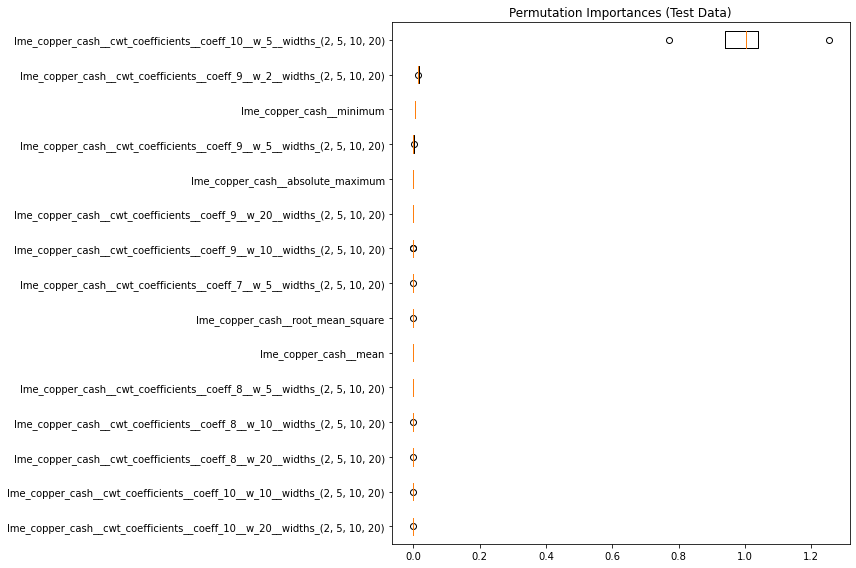

In [26]:
# Visualisierung der Feature Importance für die 15 wichtigsten Features auf den Testdaten
sorted_idx = vip_rf.importances_mean[:15].argsort()

fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot(
    vip_rf.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances (Test Data)")
fig.tight_layout()
plt.show()

### Gradient Boosting Tree Regressor

In [27]:
# Erstellen des Modells ohne Festlegung definierter Hyperparameter (Verwendung der Default-Werte)
xgb_regr = GradientBoostingRegressor(random_state=1234, verbose=True)

In [28]:
# Trainieren des Modells
xgb_regr.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1      888674.4507            1.19s
         2      725672.3462            1.22s
         3      592904.6419            1.19s
         4      485089.3905            1.17s
         5      397111.0627            1.16s
         6      325169.8010            1.14s
         7      266677.8336            1.11s
         8      219051.2584            1.10s
         9      180267.8835            1.09s
        10      148446.5946            1.08s
        20       23963.8181            0.97s
        30        5706.5429            0.84s
        40        2326.4399            0.72s
        50        1314.7746            0.60s
        60         871.6285            0.48s
        70         626.5408            0.36s
        80         475.3933            0.24s
        90         383.9282            0.12s
       100         314.1885            0.00s


GradientBoostingRegressor(random_state=1234, verbose=True)

In [29]:
# Anwenden des Modells auf die Testdaten
xgb_regr.predict(x_test)

array([6525.03458337, 6492.80651582, 6536.85771328, 6541.91961565,
       6533.60124051, 6507.75333135, 6517.21053364, 6207.99469334,
       5961.69591051, 5903.22715303, 5787.94645173, 5810.50480439,
       5838.87602738, 5791.05405871, 5924.22475931, 5955.85157154,
       5945.34089863, 5983.37131597, 6005.65982157, 5984.83975726,
       5777.21962817, 5674.30855903, 5703.27133827, 5649.04598826,
       5688.68895495, 5761.44549086, 5768.34863028, 5738.38181429,
       5646.93185623, 5678.94968278, 5721.24591099, 5786.53249954,
       5806.7568871 , 5913.53526076, 5853.21769966, 5815.41413317,
       5890.8937177 , 5886.09099602, 6066.36643289, 6107.81991989,
       6301.30833682, 6252.81994747, 6117.9576231 , 6236.40284838,
       6118.46279551, 5792.41180158, 5729.47405141, 5621.27974417,
       5666.02289551, 5637.47504728, 5671.44341533, 5594.86524636,
       5188.17894607, 4787.66431656, 4804.14917335, 4778.44028307,
       4829.56525679, 5011.20942719, 5048.70586405, 5007.45686

In [30]:
# Kalkulieren des R2
xgb_regr.score(x_test,y_test)

0.956021095875742

#### Hyperparameteroptimierung mit GridSearch

In [31]:
# Definition der Parameter und ihrer Wertebereiche für das Hyperparametertuning im Rahmen des Modelltrainings als Dict
xgb_param = {'n_estimators':[350,400,500], 
            'max_depth':[10,15,20],
            'learning_rate':[0.01,0.05,0.1]
            ,'loss': ['absolute_error']}

In [32]:
# Erstellen des GridSearch-Objekts
xgb_regr_gridsearch = GridSearchCV(xgb_regr, xgb_param, scoring='r2')

In [33]:
# Trainieren des Modells unter Verwendung der GridSearch-Methode mit 5-fold-cv
xgb_regr_gridsearch.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         708.4868            4.19s
         2         701.4687            4.70s
         3         695.1580            4.51s
         4         688.8181            4.85s
         5         682.6356            4.83s
         6         675.9013            4.65s
         7         669.3327            4.46s
         8         662.6512            4.32s
         9         656.0384            4.21s
        10         649.5265            4.15s
        20         588.2442            4.29s
        30         530.9937            4.25s
        40         479.3561            4.12s
        50         432.9649            4.04s
        60         389.8917            4.04s
        70         351.3712            4.01s
        80         317.4435            3.91s
        90         286.6289            3.84s
       100         259.1181            3.78s
       200         101.3936            2.64s
       300          45.1980            0.99s
      Ite

GridSearchCV(estimator=GradientBoostingRegressor(random_state=1234,
                                                 verbose=True),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'loss': ['absolute_error'], 'max_depth': [10, 15, 20],
                         'n_estimators': [350, 400, 500]},
             scoring='r2')

In [34]:
# Ausgabe der besten Parameter aus dem Hyperparametertuning mit 5-fold-cross-validation
xgb_regr_gridsearch.best_params_

{'learning_rate': 0.05,
 'loss': 'absolute_error',
 'max_depth': 10,
 'n_estimators': 400}

In [35]:
# Ausgabe der besten Performance (R2) aus dem Hyperparametertuning mit 5-fold-cross-validation
xgb_regr_gridsearch.best_score_

-0.205588811066382

In [36]:
# Ausgabe der Ergebnisse der Cross Validation
xgb_regr_gridsearch.cv_results_

{'mean_fit_time': array([ 7.53956819,  8.85143018, 11.64124694,  8.26140842, 10.10680108,
        12.44555116,  7.9752212 ,  9.41588712, 12.61518974,  9.47378025,
        10.92904196, 13.86142254, 10.44371066, 12.08182812, 15.32046256,
        10.32924948, 12.21121445, 15.47665839,  9.65312147, 11.05688114,
        13.93842349, 10.49539671, 12.07169042, 15.25748382, 10.76655045,
        12.43501592, 15.61991692]),
 'std_fit_time': array([0.26473983, 0.25537416, 0.22179755, 0.63163345, 0.56276067,
        0.4450438 , 0.3131286 , 0.31859626, 0.3229831 , 0.07366416,
        0.06194557, 0.0567831 , 0.11435287, 0.2270847 , 0.24125451,
        0.25617693, 0.38785578, 0.09677985, 0.07088344, 0.098701  ,
        0.12879257, 0.11975314, 0.17759833, 0.19333799, 0.22951241,
        0.31941899, 0.38806622]),
 'mean_score_time': array([0.0036015 , 0.00476751, 0.00517893, 0.00360084, 0.00459828,
        0.00479894, 0.00400186, 0.00480094, 0.00579667, 0.00380135,
        0.00479879, 0.00560026, 0.004

In [37]:
# Prognose auf den Testdaten unter Verwendung der besten Modellparameter
xgb_regr_gridsearch.predict(x_test)

array([6406.32680498, 6418.42279847, 6431.40942243, 6450.62502126,
       6431.90173436, 6426.64146092, 6406.56182594, 6327.96484201,
       6074.48785432, 5940.12143171, 5818.02905579, 5787.23676119,
       5808.72047478, 5772.29196454, 5855.88946752, 5892.82366345,
       5847.98097754, 5865.97677635, 5856.60305366, 5917.11362335,
       5819.0102826 , 5622.40093371, 5638.38349683, 5679.66487355,
       5692.71286326, 5798.77221954, 5818.94484816, 5872.23941506,
       5790.36307033, 5855.01384311, 5952.06525401, 5985.0216355 ,
       5916.38314435, 5940.82848922, 5762.78620911, 5784.45528796,
       5871.83846766, 5871.09098243, 6059.25312669, 6086.48753166,
       6189.01882168, 6199.2487106 , 6122.59838067, 6220.13696784,
       6100.89146368, 5805.93001156, 5662.22356991, 5631.5680041 ,
       5659.55593001, 5664.24266198, 5740.68740546, 5566.15505262,
       5250.12199848, 5069.48396168, 4975.05297293, 4881.30193344,
       4987.04602433, 5325.06925132, 5263.32623872, 5186.71302

In [38]:
# Bewertung der Prognoseergebnisse auf den Testdaten (R2)
xgb_regr_gridsearch.score(x_test, y_test)

0.9568682950310687

#### Feature Importance beim XGBoost

In [39]:
# Berechnung der Feature Importance des XGB-Regressors auf den Testdaten
vip = permutation_importance(xgb_regr_gridsearch, x_test, y_test, n_repeats=5,random_state=1234)

In [40]:
# Ausgabe der durchschnittlichen Feature Importance über die 5 Durchläufe
vip.importances_mean

array([ 2.53609080e-01,  4.77961798e-03,  1.12981389e-04,  6.44653529e-02,
        2.96802188e-04,  1.16427518e-04,  5.68721756e-04,  6.55860696e-03,
        2.01573267e-03,  6.40683436e-06,  3.52559591e-02,  7.81542033e-05,
        3.71184802e-04,  1.62029212e-03,  2.96963732e-04,  1.47958113e-02,
        2.66700818e-03,  4.81234679e-03,  1.98882459e-03,  2.81448973e-03,
       -3.34965369e-04,  1.21627242e-03,  2.35301080e-06, -6.57070629e-06,
        1.46685541e-03,  2.92319752e-06,  1.84472779e-05,  3.97193781e-05,
        1.89301190e-05, -1.31602250e-05, -1.00396407e-05, -1.54657254e-06,
        9.40545728e-05, -7.15150978e-06, -2.62572283e-06,  1.71259607e-06,
        2.26781743e-05, -1.12122193e-05,  8.05618900e-06,  1.02503510e-03,
        3.81196540e-04, -3.85349514e-04,  5.18493323e-04,  1.32208696e-04,
        3.23810088e-04, -9.65081931e-05, -3.16379091e-06, -4.17091349e-08,
        5.29727371e-05,  1.21772371e-01,  2.73559122e-05,  6.31956080e-06,
        8.98544259e-05,  

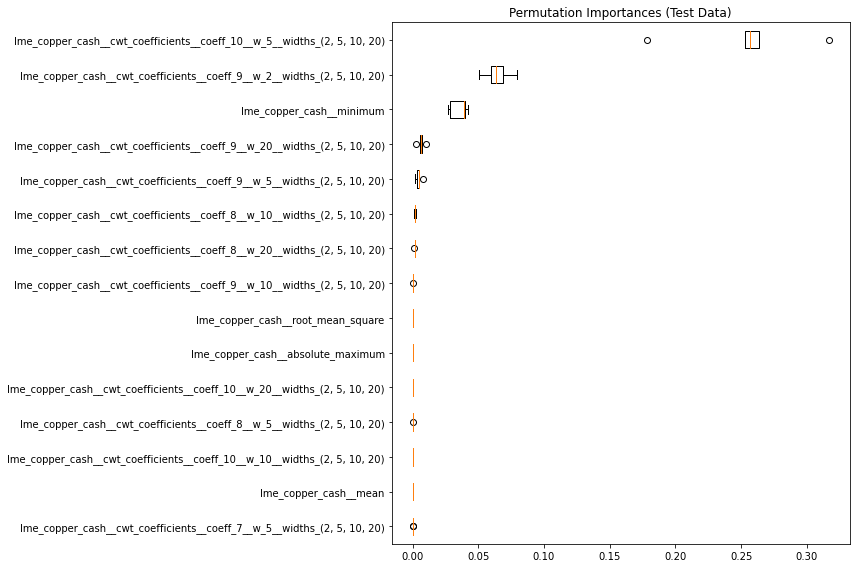

In [41]:
# Visualisierung der Importance der 15 wichtigsten Features auf den Testdaten
sorted_idx = vip.importances_mean[:15].argsort()

fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot(
    vip.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances (Test Data)")
fig.tight_layout()
plt.show()

### Zusammenfassung Decision Trees

In diesem Abschnitt wurden zwei herkömmliche Machine Learning-Modelle auf Trainingsdaten trainiert und anschließend auf den zugehörigen Testdaten evaluiert.

Bei den beiden herkömmlichen Machine Learning-Modellen handelte es sich um Decision Trees, vertreten durch den Random Forest und den Gradient Boosting Tree (XGBoost).

Beide Modelle wurden auf den gleichen Trainings- und Testdatensets trainiert und evaluiert.

Zunächst wurden beide Modelle (sowohl der Random Forest, als auch der Gradient Boosting Tree) mit Default-Parametern trainiert. Beide Modelle schnitten gut, mit einem R2-Score von 0,925 (Random Forest) und 0,956 (Gradient Boosting Tree), ab.

Für beide Modelle wurde ein Hyperparametertuning implementiert. Das Hyperparametertuning wurde mit der GridSearch-Methode durchgeführt und mit einer k-fold-cross-validation (Default = 5 folds) kombiniert.

Das implementierte Hyperparametertuning brachte beim Random Forest, bei optimalen Parametern, noch eine kleine Verbesserung. Der R2-Score konnte auf 0,931 gehoben werden.

Beim GradientBoostingRegressor (XG Boost) konnte ebenfalls eine leichte, aber nicht signifikante, Verbesserung auf einen R2-Score von 0,957 erzielt werden.

Beide Modelle liefern auf den Testdaten also, auch bereits mit Default-Parametern, eine relativ gute Performance ab.

**Auffälligkeit bei beiden Modellen**: Im Rahmen der k-fold-cross-validation (hier: 5 folds) ist die Performance auf den einzelnen Folds (Splitfolgen in Trainings- und Validierungsdaten) sehr unterschiedlich und nicht sonderlich robust.


Es ist aber davon auszugehen, dass der Gradient Boosting Tree etwas robuster ist, als der Random Forest, da der Gradien Boosting Tree, wie man in der Feature Importance Analyse erkennen kann, für die Vorhersagen auf den Testdaten mehrere Features als besonders signifikant wahrnimmt, während beim Random Forest insbesondere ein Feature sehr dominant und signifikant für die Vorhersage der Kupferpreise auf den Testdaten zu sein scheint. Die Robustheit des XGB scheint demnach etwas größer zu sein, da er die Vorhersage aus mehreren höher gewichteten Features, und einer Mehrzahl an Features mit sehr geringer Gewichtung/Importance, ableitet.

## LSTM (Long short-term memory)

Das LSTM ist in der Informatik eine Technik, die zur Verbesserung der Entwicklung von künstlicher Intelligenz wesentlich beigetragen hat. Es ist eine Form der rekurrenten neuronalen Netze, die sich insbesondere für die Lösung von Zeitreihenproblemen (Zeitreihenprognose) besonders gut eignet.

Als Kontrast bzw. Vergleich zu den klassischen Machine Learning Modellen und dem CNN (Convolutional Neural Network) soll an dieser Stelle im Rahmen dieses Projektes die Umsetzung eines LSTM verprobt werden, um das vorliegende Zeitreihenproblem zu lösen.

### Data Preprocessing

Der Einsatz eines LSTM zur Prognose des Kupferpreises, mit dem von uns aufgebauten Dataset, verlangt noch einige Schritte im Rahmen des Data Preprocessings bevor die Daten für das LSTM genutzt werden können.

1. Das neuronale Netz kann nicht mit Pandas DataFrames trainiert und evaluiert werden. Die Datasets werden nach einem Split in Trainings- und Testdaten in Numpy-Arrays umgewandelt, um diese für das LSTM nutzbar zu machen.
2. Der Wertebereich der unterschiedlichen Variablen unseres Datasets ist teilweise sehr unterschiedlich, weshal eine Normalisierung/Standardisierung vorgenommen werden soll, um die Skalierung der einzelnen Features zu verkleinern. Dies war bei den Decision Tree's nicht notwendig, empfiehlt sich aber beim LSTM.

#### Normalisierung / Standardisierung der Features
Der Pandas Dataframe soll vollständig mithilfe der Min-Max-Normalisierung bearbeitet werden.
Es gibt verschiedene Wege diese Form der Normalisierung vorzunehmen. Eine Funktion in der Skicit-Learn Library steht ebenfalls zur Verfügung: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html.

In [42]:
def minmax_norm(df_input):
    return (df - df.min()) / ( df.max() - df.min())

df_new = minmax_norm(df)

In [43]:
df_new.head()

lme_copper_cash__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)  \
id date                                                                                  
1  2012-01-08                                           0.461798                         
   2012-01-15                                           0.461798                         
   2012-01-22                                           0.461798                         
   2012-01-29                                           0.461798                         
   2012-02-05                                           0.461798                         

               lme_copper_cash__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)  \
id date                                                                                 
1  2012-01-08                                            0.46226                        
   2012-01-15                                            0.46226                        
   2012-01-22                                            0.46226                        
   2012-01-29                                            0.46226                        
   2012-02-05                                            0.46226                        

               lme_copper_cash__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)  \
id date                                                                                   
1  2012-01-08                                           0.449964                          
   2012-01-15                                           0.449964                          
   2012-01-22                                           0.449964                          
   2012-01-29                                           0.449964                          
   2012-02-05                                           0.449964                          

               lme_copper_cash__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)  \
id date                                                                                 
1  2012-01-08                                           0.485251                        
   2012-01-15                                           0.485251                        
   2012-01-22                                           0.485251                        
   2012-01-29                                           0.485251                        
   2012-02-05                                           0.485251                        

               lme_copper_cash__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)  \
id date                                                                                   
1  2012-01-08                                           0.453256                          
   2012-01-15                                           0.453256                          
   2012-01-22                                           0.453256                          
   2012-01-29                                           0.453256                          
   2012-02-05                                           0.453256                          

               lme_copper_cash__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)  \
id date                                                                                 
1  2012-01-08                                           0.452844                        
   2012-01-15                                           0.452844                        
   2012-01-22                                           0.452844                        
   2012-01-29                                           0.452844                        
   2012-02-05                                           0.452844                        

               lme_copper_cash__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)  \
id date                                                                                  
1  2012-01-08                                           

#### Train-Test-Split

In [45]:
# Trainingsdaten = 80%
# Testdaten = 20%
train_size = int(len(df_new) * 0.8)
test_size = len(df_new) - train_size
train, test = df_new.iloc[0:train_size], df_new.iloc[train_size:len(df_new)]
print(len(train), len(test))

376 94


#### Formatierung und Umwandlung des DataFrames in NumpyArrays für Trainings- und Testdaten

In [46]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [48]:
time_steps = 25

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.lme_copper_cash, time_steps)
X_test, y_test = create_dataset(test, test.lme_copper_cash, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(351, 25, 232) (351,)
(69, 25, 232) (69,)


### LSTM

#### Aufbau der Architektur des Modells

In [199]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=32,input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mae', optimizer='adam')

In [200]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 32)                33920     
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 33,953
Trainable params: 33,953
Non-trainable params: 0
_________________________________________________________________


#### Trainieren des Modells

In [201]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32,
    validation_data = (X_test,y_test),
    verbose=True,
    shuffle=False
)

Epoch 1/30
11/11 [==============================] - 3s 53ms/step - loss: 0.3399 - val_loss: 0.2861
Epoch 2/30
11/11 [==============================] - 0s 9ms/step - loss: 0.4111 - val_loss: 0.2275
Epoch 3/30
11/11 [==============================] - 0s 9ms/step - loss: 0.1251 - val_loss: 0.1622
Epoch 4/30
11/11 [==============================] - 0s 10ms/step - loss: 0.1262 - val_loss: 0.0819
Epoch 5/30
11/11 [==============================] - 0s 10ms/step - loss: 0.0894 - val_loss: 0.1114
Epoch 6/30
11/11 [==============================] - 0s 11ms/step - loss: 0.1198 - val_loss: 0.1083
Epoch 7/30
11/11 [==============================] - 0s 11ms/step - loss: 0.1231 - val_loss: 0.0627
Epoch 8/30
11/11 [==============================] - 0s 10ms/step - loss: 0.0490 - val_loss: 0.0522
Epoch 9/30
11/11 [==============================] - 0s 10ms/step - loss: 0.0589 - val_loss: 0.0679
Epoch 10/30
11/11 [==============================] - 0s 11ms/step - loss: 0.0502 - val_loss: 0.0529
Epoch 11/30

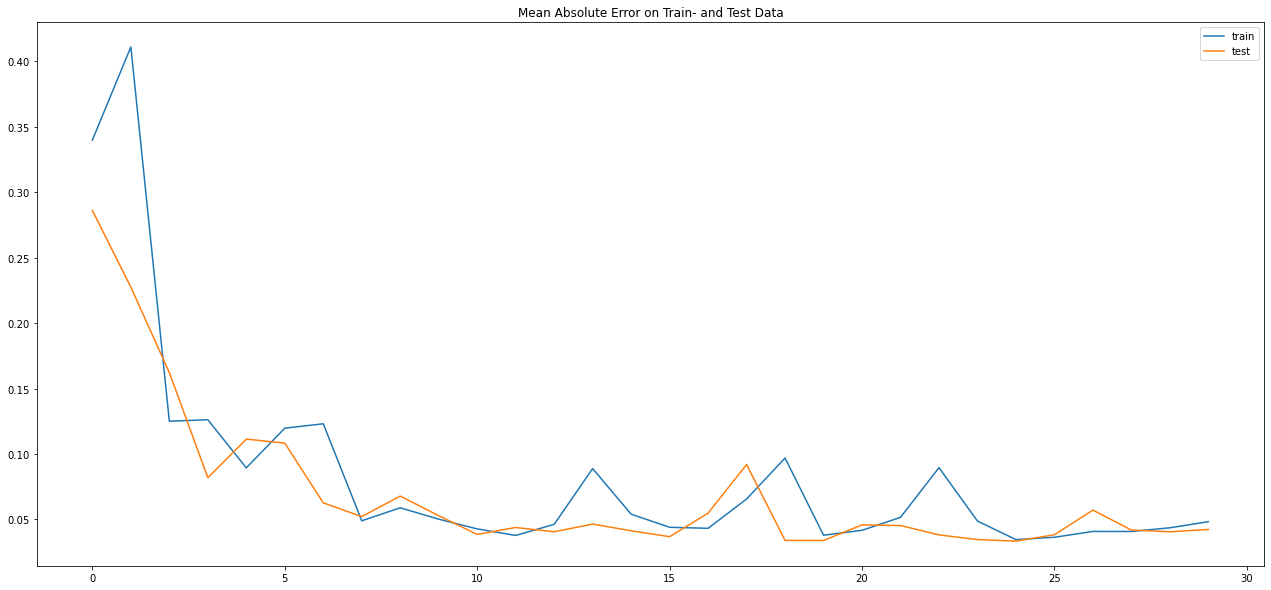

In [222]:
# Visualisierung des Lernfortschritts des LSTM über die eingestellte Anzahl an Epochen auf Trainings- und Testdaten

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Mean Absolute Error on Train- and Test Data')
plt.legend();

#### Hyperparameteroptimierung beim LSTM

In [230]:
# Defintion einer Funktion zur Definition des Modells und dessen Architektur
def create_lstm():
    # Vorbereiten der Architektur des LSTM 
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=32,input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(keras.layers.Dropout(rate=0.3))
    model.add(keras.layers.Dense(units=1))
    

    # Kompilieren des Modells und Angabe wichtiger Hyperparameter für das Modelltraining
    model.compile(loss='mae', optimizer='adam')
    return model

In [231]:
lstm_model = KerasRegressor(build_fn=create_lstm, verbose = 1)

C:\Users\woelk\AppData\Local\Temp/ipykernel_13880/1245223401.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=create_lstm, verbose = 1)


In [236]:
# Definition und Anwendung der Grid für die Hyperparameteroptimierung (Wertebereiche für das Tuning)
param_grid = dict(epochs=[10,20], batch_size=[4,8,16,32])
grid = GridSearchCV(estimator=lstm_model, scoring='neg_mean_absolute_error', param_grid=param_grid, cv=3)

# Trainieren des Modells mit der definierten Grid und 3-fold-cross validation
grid_result = grid.fit(X_train, y_train)

Epoch 1/10
59/59 [==============================] - 2s 6ms/step - loss: 0.1487
Epoch 2/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0598
Epoch 3/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0561
Epoch 4/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0462
Epoch 5/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0318
Epoch 6/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0356
Epoch 7/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0325
Epoch 8/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0304
Epoch 9/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 10/10
30/30 [==============================] - 0s 3ms/step
Epoch 1/10
59/59 [==============================] - 3s 6ms/step - loss: 0.1530
Epoch 2/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0602
Epoch 3/10
59/59 [==============================] - 0s 6ms/step - 

In [237]:
# Performance je Hyperparameterkombination
grid_result.cv_results_['mean_test_score']

array([-0.06901913, -0.04182642, -0.07090559, -0.04621783, -0.05933124,
       -0.06367179, -0.09335554, -0.08307517])

In [238]:
# Zusammenfassung der Hyperparameteroptimierung
print(grid_result.best_score_)
print(grid_result.best_params_)

-0.04182642499305455
{'batch_size': 4, 'epochs': 20}


#### Evaluation des LSTM

In [240]:
y_pred = grid_result.predict(X_test)

18/18 [==============================] - 0s 2ms/step


In [241]:
print(y_pred.shape)
print(y_test.shape)

(69,)
(69,)


In [242]:
# Aufbau einer Funktion zur Berechnung mehrerer Regressionsmetriken
# Innerhalb der Funktionen werden wiederum Funktionen aus dem sklearn-Package (Modul: Metrics) verwendet.

def determineRegressionMetrics(y_test,y_pred,title=""):
    mse = mean_squared_error(y_test, y_pred)
    mad = mean_absolute_error(y_test, y_pred)
    rmsle=np.sqrt(mean_squared_error(np.log(y_test+1),np.log(y_pred+1)))# +1 for avoiding log(0) 
    r2=r2_score(y_test, y_pred)
    med=median_absolute_error(y_test, y_pred)
    print(title)
    print("Mean absolute error =", round(mad, 2))
    print("Mean squared error =", round(mse, 2))
    print("Median absolute error =", round(med, 2))
    print("R2 score =", round(r2, 2))
    print("Root Mean Squared Logarithmic Error =",rmsle)

In [243]:
# Kalkulieren der Metriken für die aktuelle Vorhersage auf den Testdaten
determineRegressionMetrics(y_test,y_pred)


Mean absolute error = 0.03
Mean squared error = 0.0
Median absolute error = 0.03
R2 score = 0.95
Root Mean Squared Logarithmic Error = 0.028686629622943386


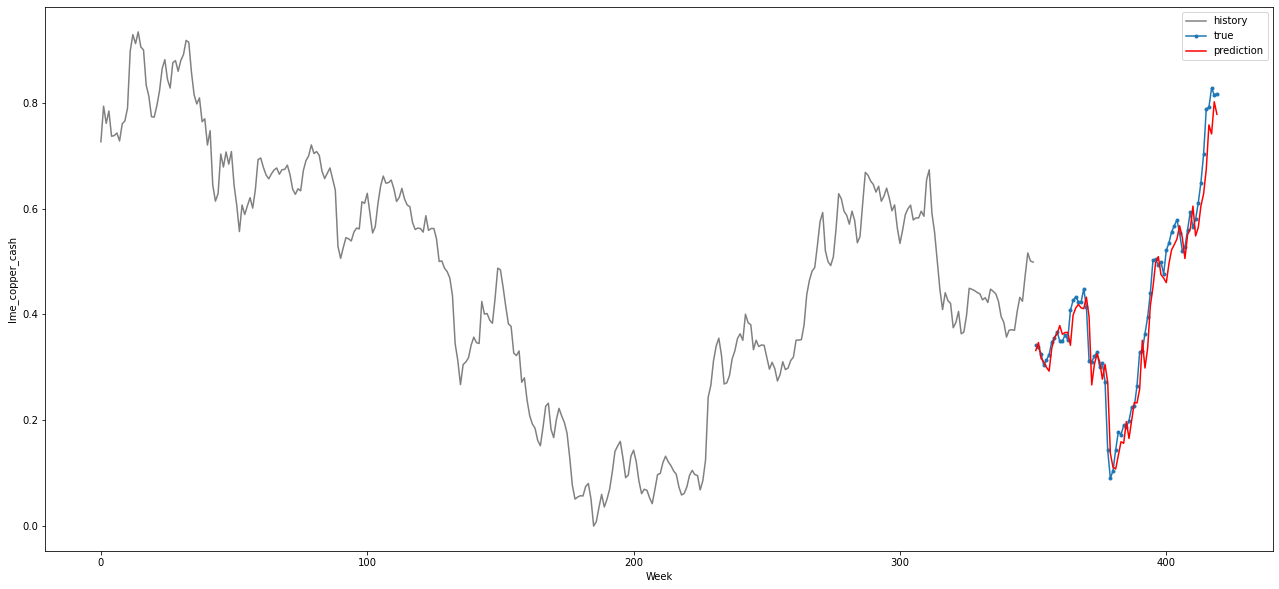

In [244]:
# Visualisieren der gesamten Zeitreihe inkl. Prediction
plt.plot(np.arange(0, len(y_train)), y_train, '0.5', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('lme_copper_cash')
plt.xlabel('Week')
plt.legend()
plt.show();

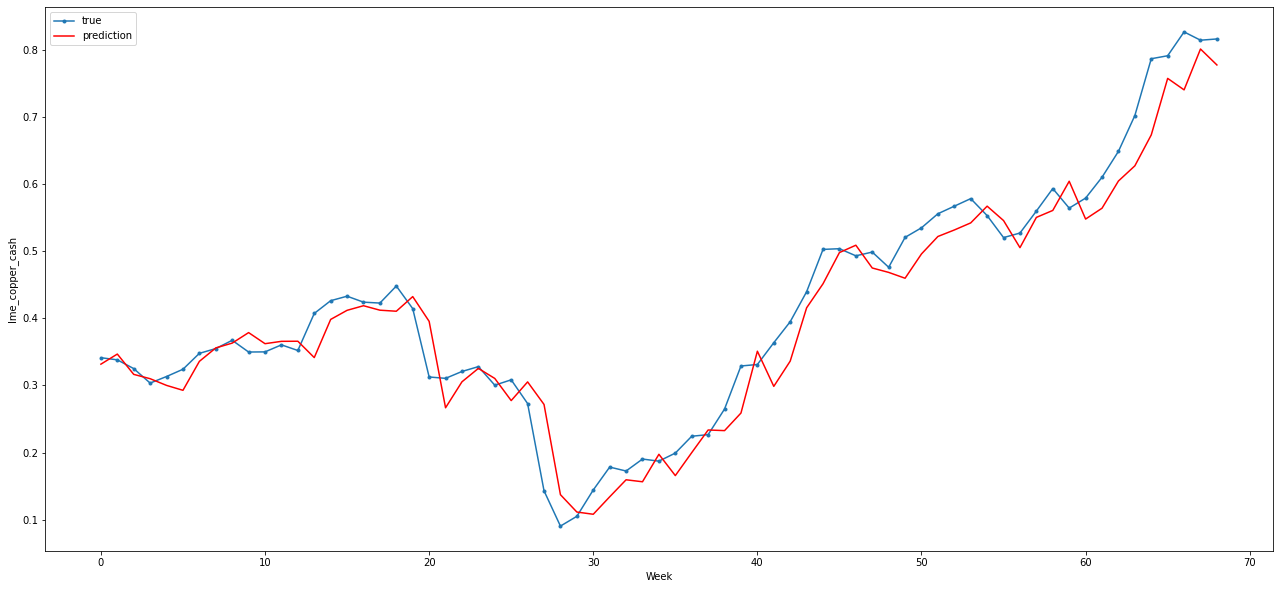

In [245]:
# Visualisierung der Performance (Prognosegüte) auf den Testdaten
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('lme_copper_cash')
plt.xlabel('Week')
plt.legend()
plt.show();